# ws 03 Denoise Text

- dataset - https://www.kaggle.com/c/denoising-dirty-documents/data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                                     Dropout, Conv2DTranspose)
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Google Colab
from google.colab import drive
drive.mount('/content/drive')

%ls '/content/drive/MyDrive/Colab Notebooks/datasets'

Mounted at /content/drive
sampleSubmission.csv  test/  train/  train_cleaned/


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/datasets/'
# path = 'datasets/'

In [4]:
# imgW, imgH = 300, 240
imgW, imgH = 540, 420

In [5]:
train_img = sorted(os.listdir(path + 'train'))
train_cleaned_img = sorted(os.listdir(path + 'train_cleaned'))
test_img = sorted(os.listdir(path + 'test'))

print(f'X Train: {len(train_img)} , Y Train: {len(train_cleaned_img)}')
print('X Test:', len(test_img))

train_img[:5]

X Train: 144 , Y Train: 144
X Test: 72


['101.png', '102.png', '104.png', '105.png', '107.png']

(420, 540, 1)


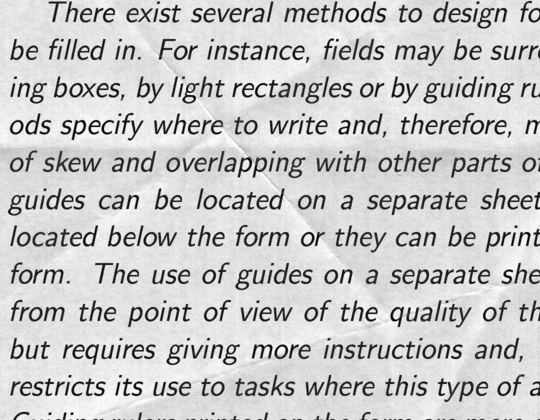

In [6]:
img = load_img(path+'train/'+train_img[0], target_size=(imgH, imgW),
              color_mode='grayscale')
print(img_to_array(img).shape)

img

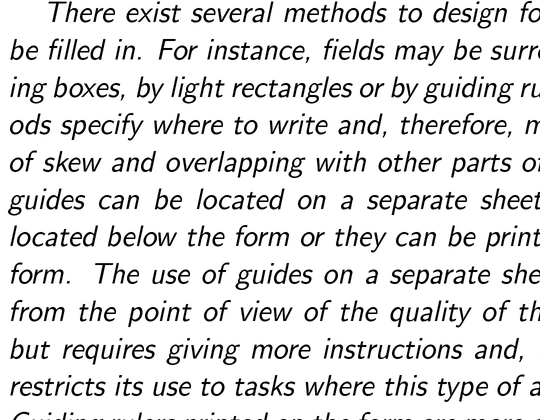

In [7]:
img = load_img(path+'train_cleaned/'+train_img[0], target_size=(imgH, imgW))
img

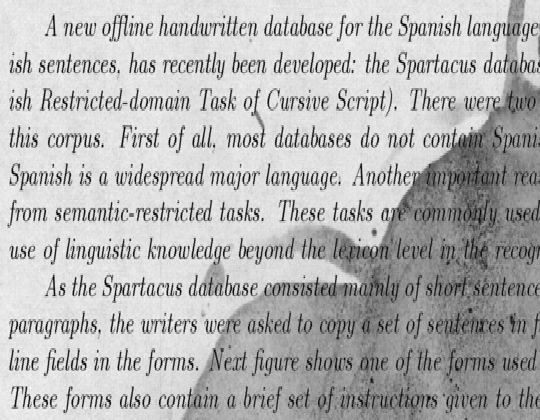

In [8]:
img = load_img(path+'test/'+test_img[0], target_size=(imgH, imgW))
img

In [9]:
def process_image(file):
    img = load_img(file, target_size=(imgH, imgW), color_mode='grayscale')
    img = img_to_array(img)
    img = img/255.0
    return img

In [10]:
train = []
train_cleaned = []
test = []

for f in tqdm(train_img):
    train.append(process_image(path + 'train/' + f))

for f in tqdm(train_cleaned_img):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))

for f in tqdm(test_img):
    test.append(process_image(path + 'test/' + f))


100%|██████████| 72/72 [00:30<00:00,  2.37it/s]


In [11]:
print('Train0 shape:', train[0].shape)

Train0 shape: (420, 540, 1)


In [12]:
plt.figure(figsize=(15,22))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Clean image: {}'.format(train_img[i]))

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15)

X_train.shape, X_val.shape

((122, 420, 540, 1), (22, 420, 540, 1))

### Model

In [14]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = Sequential([
#             InputLayer(input_shape=(imgW, imgH, 1)),
            Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            # BatchNormalization(),
            # MaxPooling2D((2, 2), padding='same'),
            Dropout(0.4) ])

        self.decoder = Sequential([
            Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
callback = EarlyStopping(monitor='loss', patience=20)
history = autoencoder.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=16, verbose=1, callbacks=[callback])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - loss: 0.6092 - val_loss: 0.3721
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 366ms/step - loss: 0.3718 - val_loss: 0.3374
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - loss: 0.3321 - val_loss: 0.3102
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - loss: 0.3115 - val_loss: 0.2915
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 352ms/step - loss: 0.2868 - val_loss: 0.2622
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - loss: 0.2579 - val_loss: 0.2276
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - loss: 0.2253 - val_loss: 0.2076
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - loss: 0.2092 - val_loss: 0.1918
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 0.1943 - val_loss: 0.1778
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - loss: 0.1769 - val_loss: 0.1595
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 0.1611 - val_loss: 0.1469
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step - loss: 0.14

In [16]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 210, 270, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 105, 135, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 105, 135, 128)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,496 (291.00 KB)

 Trainable params: 74,496 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose (Conv2DTranspose)   │ (None, 210, 270, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 420, 540, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 420, 540, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 221,953 (867.00 KB)

 Trainable params: 221,953 (867.00 KB)

 Non-trainable params: 0 (0.00 B)

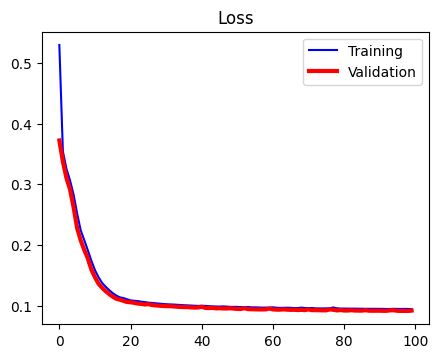

In [17]:
plt.figure(figsize=(5, 3.8))
plt.plot(history.history['loss'], color='b', label="Training")
plt.plot(history.history['val_loss'], 'r', lw=3, label="Validation")
plt.title('Loss')
plt.legend()
plt.show()

In [18]:
# clean test images
Y_pred = autoencoder.predict(X_test, batch_size=16)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


In [19]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))

    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by Autoencoder: {}'.format(test_img[i]))

plt.show()

Output hidden; open in https://colab.research.google.com to view.

## clean Text

In [20]:
from google.colab import files

uploaded = files.upload()
%ls

Saving 1.png to 1.png
1.png  drive/  sample_data/


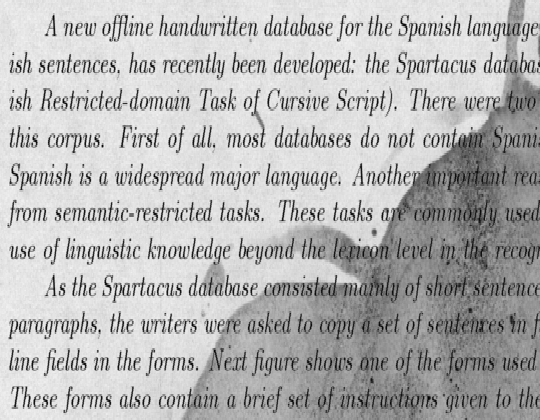

In [22]:
img = load_img('1.png', target_size=(imgH, imgW), color_mode='grayscale')
img

In [23]:
img = img_to_array(img)
img = img/255.0
print(img.shape)
print(np.max(img), np.min(img))

(420, 540, 1)
0.95686275 0.011764706


In [24]:
img = np.expand_dims(img, axis=0)
img.shape   #

(1, 420, 540, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(420, 540)


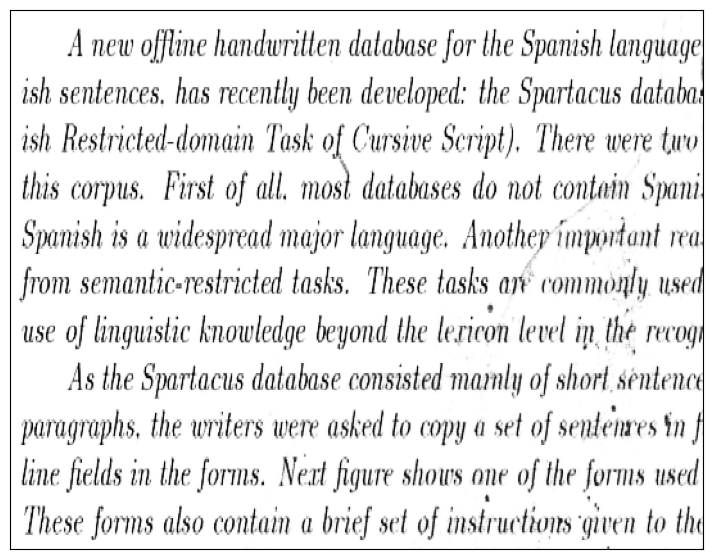

In [25]:
Y_pred = autoencoder.predict(img)
Y_pred = np.squeeze(Y_pred)
print(Y_pred.shape)

plt.figure(figsize=(10, 7))
plt.imshow(Y_pred, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

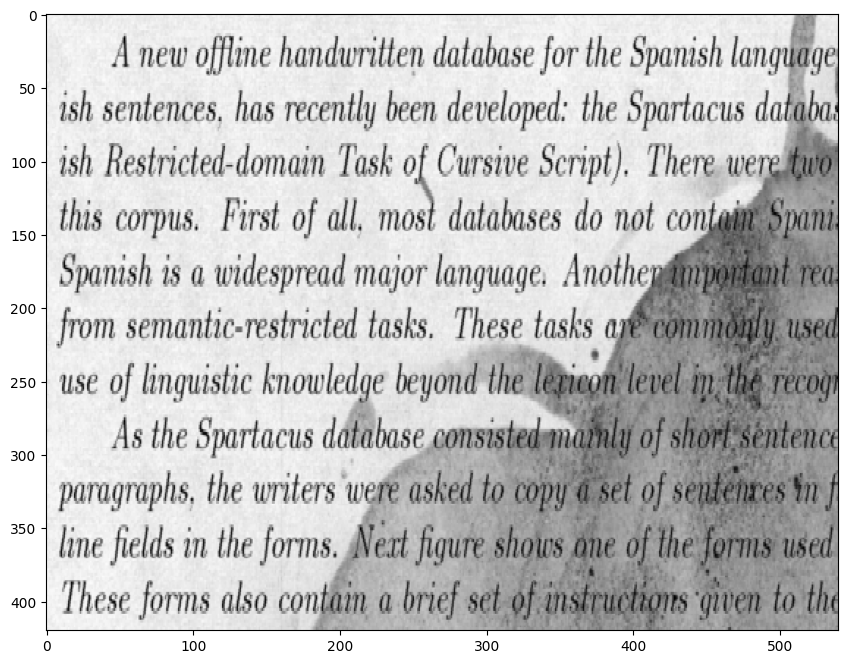

In [26]:
plt.figure(figsize=(12, 8))
plt.imshow(np.squeeze(img), cmap='gray')
plt.show()